In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Projection is not always the best approach to dimensionality reduction.
For example, consider the famous *Swiss roll* toy dataset

Text(0.5, 0.92, 'Swiss roll dataset')

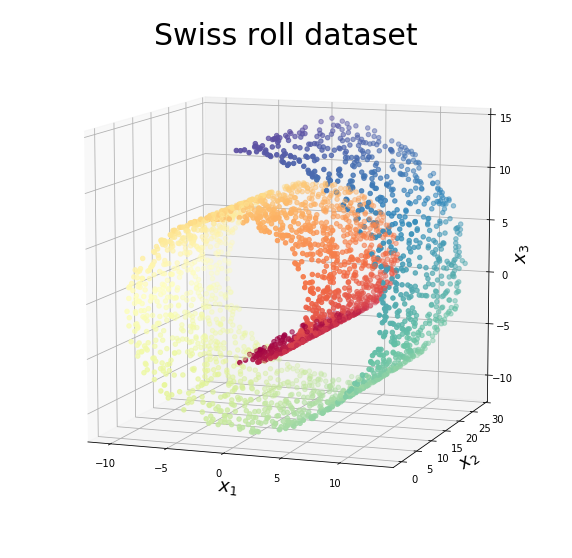

In [171]:
'Make a Swiss roll'
m = 3000
t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, m))
x1 = t * np.cos(t)
x2 = 30* np.random.rand(1, m)
x3 = t * np.sin(t)
X = np.concatenate((x1, x2, x3))
X = X.T
t = np.squeeze(t)

'Plot the Swiss roll'
axes = [-11.5, 14, -2, 30, -12, 15]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Swiss roll dataset',fontsize=30)

Let's use PCA to project the *Swiss roll* into a two-dimensional subspace

In [159]:
'PCA'
# center the dataset
X_centered = X - np.mean(X,axis=0)

# Singular Value Decomposition
u,s,v = np.linalg.svd(X_centered)

# principal components
k = 2 
c = v[:,:k] 

# projection
X_reduced = X_centered@v[:k].T

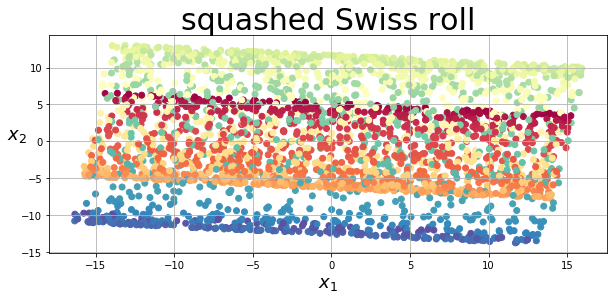

In [160]:
'plot PCA projection'
plt.figure(figsize=(10,4))
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=t, cmap=plt.cm.Spectral)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.title('squashed Swiss roll',fontsize=30)
plt.grid(True)

PCA squashes different layers of the Swiss roll together. 
What we really want is to "unroll" the Swiss roll.

## 11.3 - Locally Linear Embedding (LLE)

The Swiss roll is an example of a two-dimensional **manifold** embedded in a three-dimensional space.
Key property of a manifold: locally, a manifold looks flat. **Locally linear embedding (LLE)** is a clever scheme that exploits this property for unrolling twisted manifolds.

Here's how LLE works:

### 11.3.1 - Locally Linear Embedding Step by Step

**Step 1:** First, for each dataset point, the algorithm identifies its $k$ closest neighbors (in the preceding code $k=10$).

In [161]:
n_neighbors = 10
m,n = X.shape
# compute all pairwise distances
distance = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        distance[i,j] = np.linalg.norm(X[i]-X[j])
#  find local neighborhoods for each point
index = np.argsort(distance,axis=1)
neighborhoods = index[:,1:n_neighbors+1]

The above code is slow. A better approach uses scipy distance function

In [172]:
'faster alternative'
from scipy.spatial import distance
n_neighbors = 10
m,n = X.shape
# compute all pairwise distances
distances = distance.squareform(distance.pdist(X))
#  Find local neighborhoods for each point
index = np.argsort(distances,axis=1)
neighborhoods = index[:,1:n_neighbors+1]

For example, the closest neighbors of $X[0]$ 

In [163]:
X[0]

array([ 9.66042746, 16.7876403 ,  9.17960572])

are

In [164]:
X[neighborhoods[0]]

array([[ 9.56448165, 16.29019057,  9.29570298],
       [10.1177305 , 16.77678891,  8.58641792],
       [ 9.67484816, 17.71733307,  9.16192259],
       [ 9.9906982 , 17.84091668,  8.7582643 ],
       [ 8.75364487, 17.07569776, 10.1812902 ],
       [ 9.10501346, 17.89979871,  9.8170381 ],
       [10.57234096, 17.02986477,  7.91895413],
       [10.68979475, 16.56540252,  7.73115584],
       [10.26008042, 15.28963198,  8.38669504],
       [ 9.49973637, 18.63829849,  9.37255747]])

 **Step 2:** Second, the algorithm tries to reconstruct each point as a **linear combination** of its $k$ closest neighbors.
 More specifically, if we denote by $\bar{x}_1,\bar{x}_2,\ldots,\bar{x}_k$ the $k$ closest neighbors of $x_i$, the algorithm finds the weights $w_{ij}$ that minimize
 
 $$
\| x_i - \sum_{j=1}^k w_{ij} \bar{x}_j \|_2^2 + \lambda \sum_{j=1}^k w_{ij}^2
 $$
 
 subject to the condition
 
 $$
 \sum_{j=1}^k w_{ij} = 1.
 $$
 
 The regularization term $\lambda \sum_{j=1}^k w_{ij}^2$ is there to prevent overfitting issues, and the condition $\sum_{j=1}^k w_{ij} = 1$ is imposed to make the algorithm invariant to translations of the dataset.

Using the matrix and the (row) vector

$$
\bar{X}_i = 
\begin{bmatrix}
    \bar{x}_1 \\ \bar{x}_2 \\ \vdots \\ \bar{x}_k
\end{bmatrix}
\qquad \mbox{and} \qquad
w =
\begin{bmatrix}
    w_{i1} & w_{i2} & \cdots & w_{ik}
\end{bmatrix},
$$

the problem of finding the weights becomes:

\begin{align}
&\mbox{minimize }\, \| x_i - w \bar{X}_i \|_2^2 + \lambda \|w\|_2^2 \\
&\mbox{subject to }\, \sum_{j=1}^k w_{ij} = 1
\end{align}

This is a constrained optimization problem, and its solution  can be computed in closed form (hooray for linear algebra!!); see the problem at the end of the Jupyter Notebook.

First, we form the matrix

$$
Z_i = \begin{bmatrix}
    \bar{x}_1-x_i \\ \bar{x}_2-x_i \\ \vdots \\ \bar{x}_k-x_i
\end{bmatrix}.
$$

Second, we compute the matrix

$$
C_i = Z_i Z_i^T + \lambda I_k.
$$

Third, we solve the linear system

$$
C_i \, w^T = 
\begin{bmatrix}
    1 \\ 1 \\ \vdots \\ 1
\end{bmatrix}
$$

for the vector $w$.

Finally, we normalize $w$ so that its entries add up to 1.

In [174]:
lam = 1e-3 # regularization parameter
W = np.zeros((m,m)) # store the weights in this matrix
for i in range(m):
    Z = X[neighborhoods[i]]-X[i] # form matrix Z
    C = Z@Z.T # compute matrix C
    C = C + lam*np.identity(n_neighbors)*np.linalg.norm(Z) # add the regularization term
    w = np.linalg.solve(C,np.ones(n_neighbors)) # solve the linear system
    W[i,neighborhoods[i]] = w/np.sum(w) # normalize w

After this step, the weight matrix $W$ (containing the weights $w_{ij}$) encodes the local linear relationshipts between tha dataset points.

**Step 3:** The goal of the LLE algorithm is to preserve the local linear structure of the high-dimensional
space as accurately as possible in a low-dimensional space.
Hence, the matrix $W$ is kept fixed and embedded coordinates $y_i$ are sought by minimizing the following function

$$
\sum_{i=1}^m \|y_i - \sum_{i=1}^m w_{ij}y_j \|_2^2.
$$

Using the matrix

$$
Y = 
\begin{bmatrix}
    y_1 \\ y_2 \\  \vdots \\ y_m
\end{bmatrix},
$$

the problem of finding the embedded coordinates $y_i$ becomes

$$
\mbox{minimize }\sum_{i=1}^m \| \mbox{ row $i$ of } (I_m-W)Y\|_2^2
$$

This optimization problem also has a closed-form solution. To solve it, first we form the matrix

$$
M = (I_m-W)^T(I_m-W).
$$

If we are embedding the dataset into a space of dimension $d$, then the columns of $Y$ are the eigenvectors of $M$ associated with the $d$ smallest nonzero eigenvalues.

In [175]:
d = 2
from scipy.sparse.linalg import eigsh # function for finding eigenvalues and eigenvectors of symmetric matrices

#M = (np.identity(m)-W).T@(np.identity(m)-W)
M = np.identity(m)-W.T-W+W.T@W
evalues,evectors = eigsh(M, 
                         k=d+1, 
                         sigma = 0, # compute the eigenvectors with the smallest eigenvalues
                         maxiter = 100, 
                         tol = 1e-06)
index = np.argsort(evalues) # sort eigenvalues
reduced_X = np.real(evectors[:,index[1:d+1]]) # drop the eigenvector with eigenvalue equal to 0

The resulting 2D dataset is shown in the figure below. 
As you can see, the Swiss roll is completely unrolled, and the distances between points are locally preserved.

Text(0.5, 1.0, 'unrolled Swiss roll')

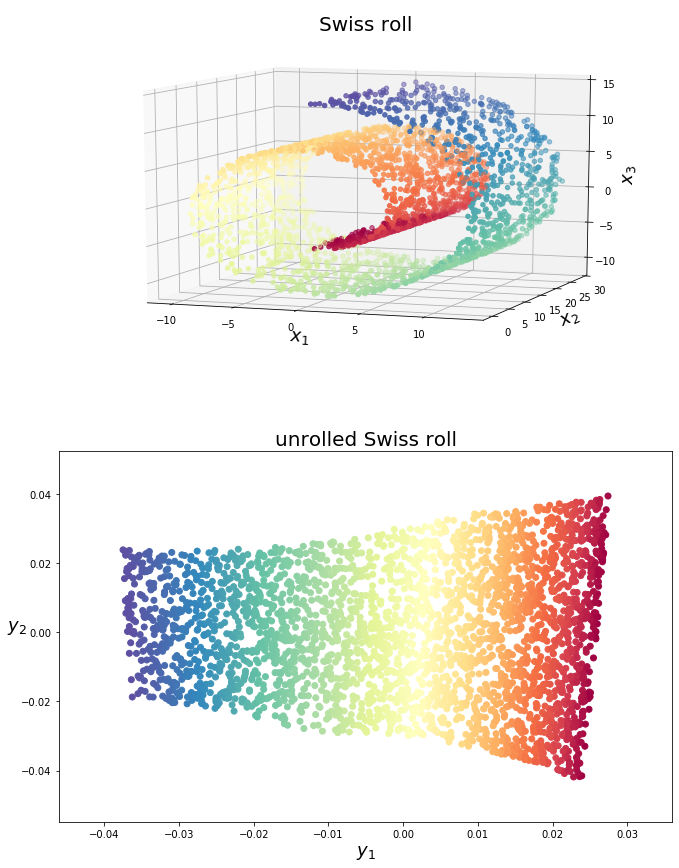

In [176]:
'plot the Swiss roll and the unrolled Swiss roll'

fig = plt.figure(figsize=(11, 15))

# Swiss roll
ax = plt.subplot(2,1,1, projection='3d')
axes = [-11.5, 14, -2, 30, -12, 15]
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Swiss roll',fontsize=20)

# unrolled Swiss roll
plt.subplot(2,1,2)
plt.scatter(reduced_X[:,0],reduced_X[:,1],c=t,cmap=plt.cm.Spectral)
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18, rotation=0)
plt.title('unrolled Swiss roll',fontsize=20)

Amazing, isn't it?

## 11.3.1 Locally Linear Embedding Implementation

In [2]:
def lle(X,d=2,n_neighbors=5):
    from scipy.spatial import distance
    from scipy.sparse.linalg import eigsh
    from scipy.linalg import solve

    m,n = X.shape
    'step 1: compute pairwise distances and find neighbors'
    print('step 1: computing pairwise distances')
    distances = distance.squareform(distance.pdist(X))        
    index = np.argsort(distances,axis=1)
    neighbors = index[:,1:n_neighbors+1]
    
    'step 2: solve for reconstruction weights'
    print('step 2: computing weights')
    if n_neighbors>m:
        lam = 1e-3
    else:
        lam = 0
    reg = 1e-3
    W = np.zeros((m,m))
    for i in range(m):
        Z = X[neighbors[i]]-X[i]
        C = Z@Z.T
        C = C + reg*np.identity(n_neighbors)*np.linalg.norm(Z)
        w = solve(C,np.ones(n_neighbors),sym_pos=True)
        W[i,neighbors[i]] = w/np.sum(w)


    'step 3: compute embedding from eigenvectors of the matrix (I-W)^T*(I-W)'
    print('step 3: computing new points')
    M = np.identity(m)-W.T-W+W.T@W
    tol = 1e-05
    max_iter=100
    evalues,evectors = eigsh(M, 
                             k=d+1, 
                             sigma = 0, 
                             maxiter = max_iter, 
                             tol = tol)
    index = np.argsort(evalues)
    reduced_X = np.real(evectors[:,index[1:d+1]])
    return reduced_X

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


Text(0.5, 1.0, 'unrolled Swiss roll')

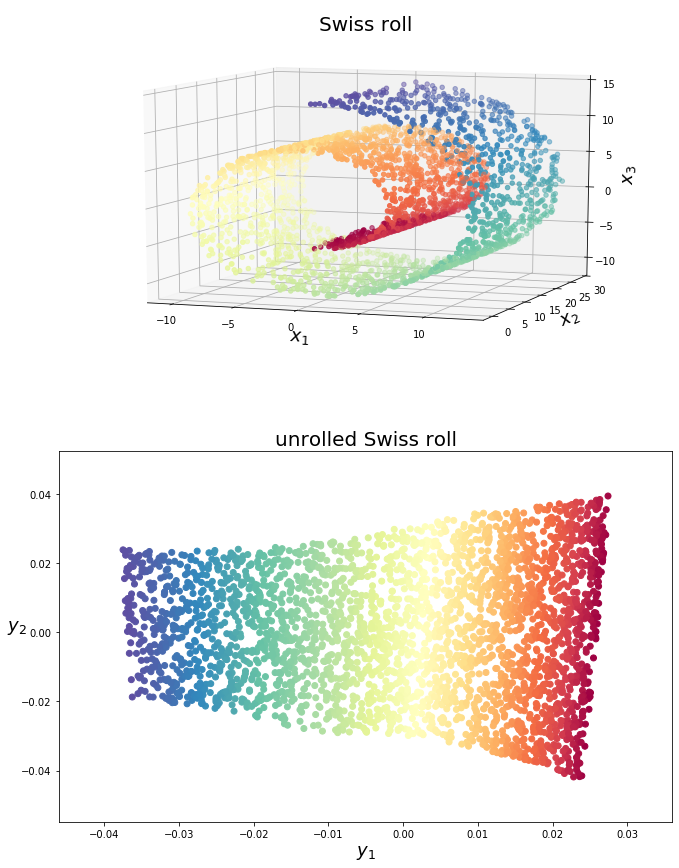

In [178]:
'test lle'
reduced_X = lle(X,
                d = 2,
                n_neighbors = 10)
'Plot original and reduced datasets'
fig = plt.figure(figsize=(11, 15))
# Swiss roll
ax = plt.subplot(2,1,1, projection='3d')
axes = [-11.5, 14, -2, 30, -12, 15]
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Swiss roll',fontsize=20)

# unrolled Swiss roll
plt.subplot(2,1,2)
plt.scatter(reduced_X[:,0],reduced_X[:,1],c=t,cmap=plt.cm.Spectral)
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18, rotation=0)
plt.title('unrolled Swiss roll',fontsize=20)

In [179]:
def lle_sparse(X,d=2,n_neighbors=5):
    'Use this version if the dataset is big'
    from scipy.spatial import distance
    from scipy.sparse import eye
    from scipy.sparse.linalg import eigsh
    from scipy.linalg import solve
    from sklearn.utils import check_random_state
    
    m,n = X.shape
    'step 1: compute pairwise distances and find neighbors'
    print('step 1: computing pairwise distances')
    distances = distance.squareform(distance.pdist(X))
            
    index = np.argsort(distances,axis=1)
    neighbors = index[:,1:n_neighbors+1]
    
    'step 2: solve for reconstruction weights'
    print('step 2: computing weights')
    reg = 1e-3
    W = np.zeros((m,n_neighbors))
    for i in range(m):
        Z = X[neighbors[i]]-X[i]
        C = Z@Z.T
        C = C + reg*np.identity(n_neighbors)*np.linalg.norm(Z) #np.trace(C)
        w = solve(C,np.ones(n_neighbors),sym_pos=True)
        W[i] = w/np.sum(w)

    'step 3: compute embedding from eigenvectors of the matrix (I-W)^T*(I-W)'
    print('step 3: computing new points')
    'form matrix M'
    M = eye(m,format='lil') # sparse matrix
    for i in range(m):
        j = neighbors[i]
        M[i,j] = M[i,j] - W[i]
    M = (M.T * M).tocsr()
    'get eigenvectors'
    random_state = check_random_state(None)
    v0 = random_state.uniform(-1, 1, M.shape[0]) 
    tol = 1e-06
    max_iter = 100
    evalues,evectors = eigsh(M, 
                             k=d+1, 
                             sigma = 0, 
                             maxiter = max_iter, 
                             tol = tol, 
                             v0 = v0)
    reduced_X = np.real(evectors[:,1:])*np.sqrt(m)
    return reduced_X

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


Text(0.5, 1.0, 'unrolled Swiss roll')

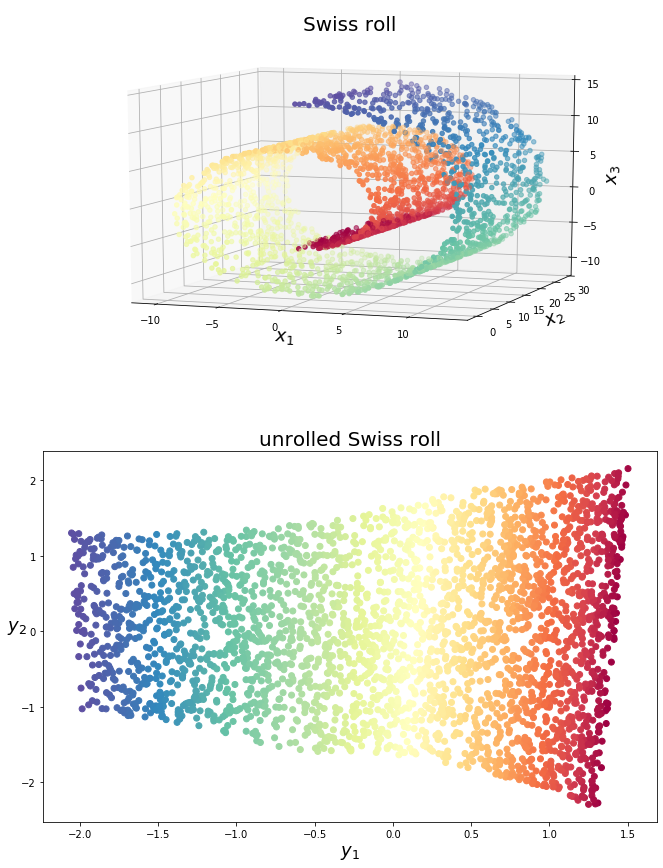

In [180]:
'test lle_sparse function'
reduced_X = lle_sparse(X,
                d = 2,
                n_neighbors = 10)
'Plot original and reduced datasets'
fig = plt.figure(figsize=(11, 15))
# Swiss roll
ax = plt.subplot(2,1,1, projection='3d')
axes = [-11.5, 14, -2, 30, -12, 15]
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('Swiss roll',fontsize=20)

# unrolled Swiss roll
plt.subplot(2,1,2)
plt.scatter(reduced_X[:,0],reduced_X[:,1],c=t,cmap=plt.cm.Spectral)
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18, rotation=0)
plt.title('unrolled Swiss roll',fontsize=20)

### 11.3.3 Examples

#### Example 1: a Spiral

In [12]:
'Make a spiral'
m = 3000
t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, m))
x = t * np.cos(t)
y = t * np.sin(t)
X = np.concatenate((x, y))
X = X.T
t = np.squeeze(t)

'Unroll the spiral'
reduced_X = lle(X,
                d = 1,
                n_neighbors = 10)

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


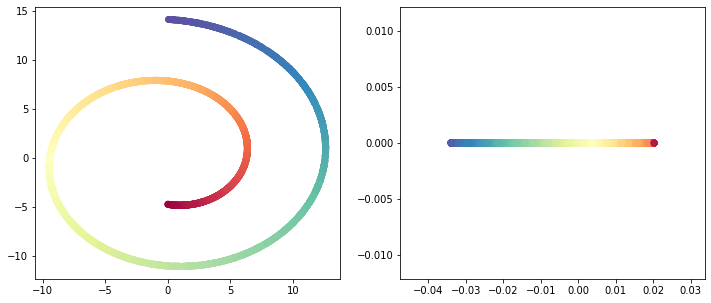

In [14]:
plt.figure(figsize=(12,5))
'Plot the spiral'
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],c=t,cmap = plt.cm.Spectral)
'Plot the unrolled spiral'
plt.subplot(1,2,2)
plt.scatter(reduced_X,np.zeros(len(reduced_X)), c=t, cmap=plt.cm.Spectral)

#### Example 2: a Sphere with a Hole

In [50]:
'Make a sphere with a hole'
m = 3000
r = 1
phi = 2 * np.pi * np.random.rand(1, m)
t = np.pi/4 + (np.pi-np.pi/4) * np.random.rand(1, m)
x = r*np.sin(t)*np.cos(phi)
y = r*np.sin(t)*np.sin(phi)
z = r*np.cos(t)
X = np.concatenate((x, y,z))
X = X.T
t = np.squeeze(t)

'Unroll the sphere'
reduced_X = lle(X,
                d = 2,
                n_neighbors = 10)

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


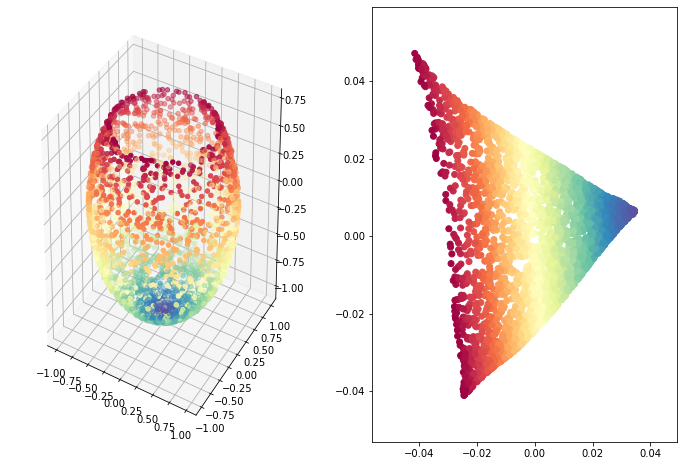

In [51]:
plt.figure(figsize=(12,8))
ax = plt.subplot(1,2,1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)


plt.subplot(1,2,2)
plt.scatter(reduced_X[:,0],reduced_X[:,1],c=t,cmap=plt.cm.Spectral)

#### Example 3: a Sphere

In [54]:
'Make a sphere'
m = 3000
r = 1
phi = 2 * np.pi * np.random.rand(1, m)
t = np.pi * np.random.rand(1, m)
x = r*np.sin(t)*np.cos(phi)
y = r*np.sin(t)*np.sin(phi)
z = r*np.cos(t)
X = np.concatenate((x, y,z))
X = X.T
t = np.squeeze(t)

'Unroll the sphere'
reduced_X = lle(X,
                d = 2,
                n_neighbors = 15)

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


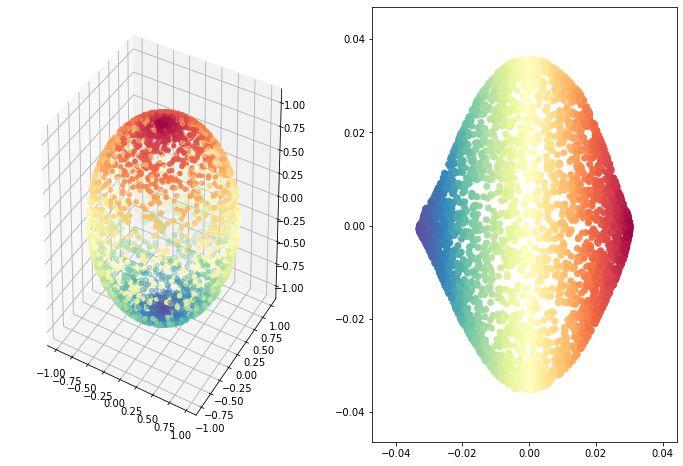

In [55]:
plt.figure(figsize=(12,8))
ax = plt.subplot(1,2,1, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)


plt.subplot(1,2,2)
plt.scatter(reduced_X[:,0],reduced_X[:,1],c=t,cmap=plt.cm.Spectral)

#### Example 4: Visualizing 3's and 5's

In [168]:
'Load the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']
X = X[:5000]
y = y[:5000]

In [169]:
y = y.astype(np.uint8)

We'll focus on digits 3 and 5, which are often misclassified

In [125]:
y35 = y[np.logical_or(y == 3, y == 5)]
X35 = X[np.logical_or(y == 3, y == 5)]
len(y35)

927

Now let's use LLE to reduce dimensionality down to 2D so we can plot the dataset:

In [126]:
reduced_X = lle(X35,
                d = 2,
                n_neighbors = 15)

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit.

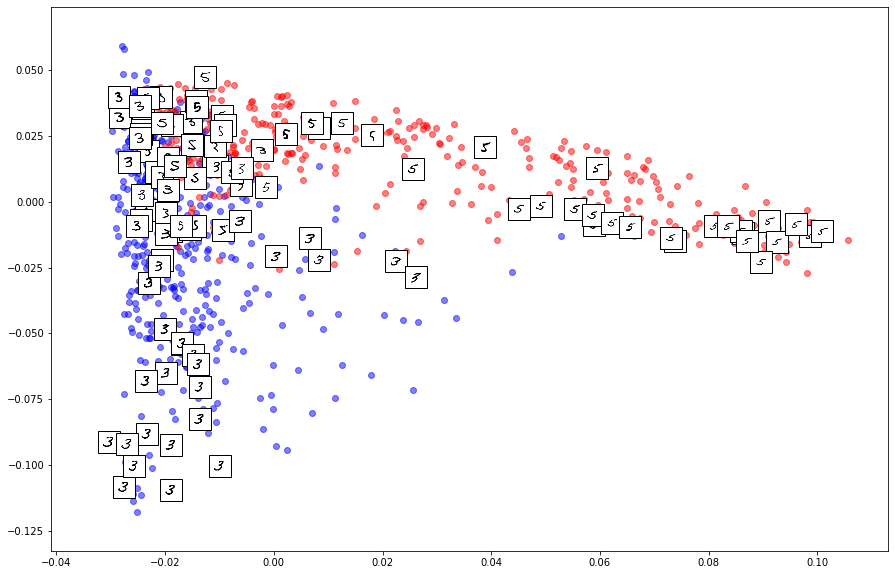

In [127]:
colors = ['blue','red']
digits = [3,5]
plt.figure(figsize=(15,10))
for i in range(2):
    plt.scatter(reduced_X[y35==digits[i],0],reduced_X[y35==digits[i],1],color=colors[i], alpha = 0.5)
ax = plt.gcf().gca()  # get current axes in current figure   

'Plot scaled-down versions of some of digit images'
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
n_digits = 100    
for i in range(n_digits):
    image = X35[i].reshape(28, 28)
    image_coord = reduced_X[i]
    imagebox = AnnotationBbox(OffsetImage(image, zoom=.5, cmap="binary"), image_coord)
    ax.add_artist(imagebox)

Isn't this just beautiful? :) This plot tells us which 3's are easily distinguishable from 5's , and it also tells us which 3's are often hard to distinguish from 5's.

Let's focus on the region where 3's and 5's seem to overlap a lot.

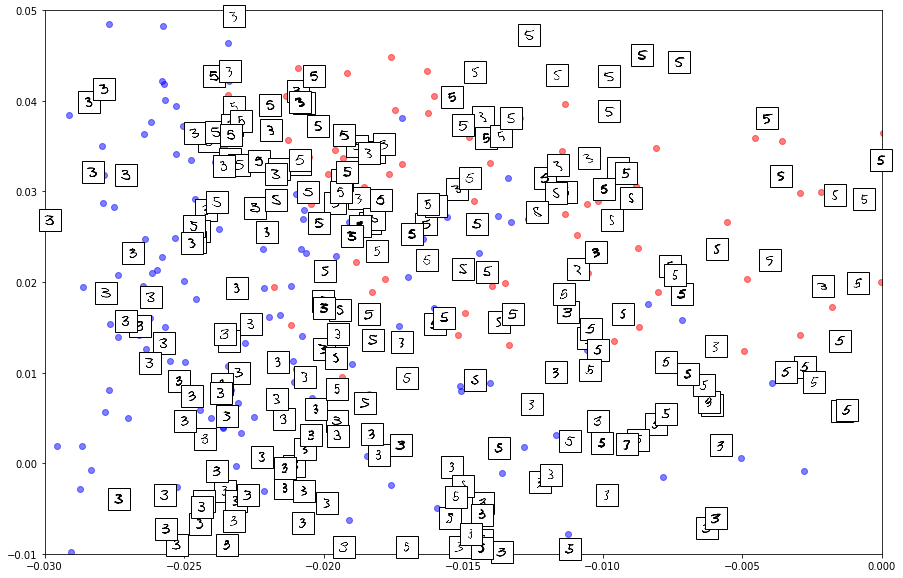

In [131]:
colors = ['blue','red']
digits = [3,5]
plt.figure(figsize=(15,10))
for i in range(2):
    plt.scatter(reduced_X[y35==digits[i],0],reduced_X[y35==digits[i],1],color=colors[i], alpha = 0.5)
ax = plt.gcf().gca()  # get current axes in current figure    
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
n_digits = 500    
for i in range(n_digits):
    image = X35[i].reshape(28, 28)
    image_coord = reduced_X[i]
    imagebox = AnnotationBbox(OffsetImage(image, zoom=.5, cmap="binary"), image_coord)
    ax.add_artist(imagebox)
    ax.axis([-0.03,0.00,-0.01,0.05]) # zoom in

#### Example 5: Visualizing all the Digits

In [ ]:
'Load the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']
X = X[:10000]
y = y[:10000]

step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points
step 1: computing pairwise distances
step 2: computing weights
step 3: computing new points


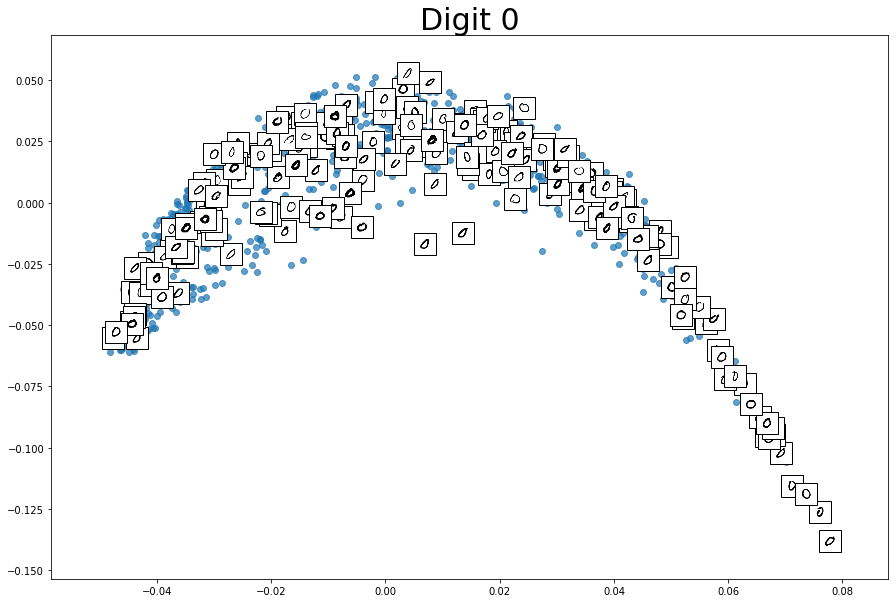

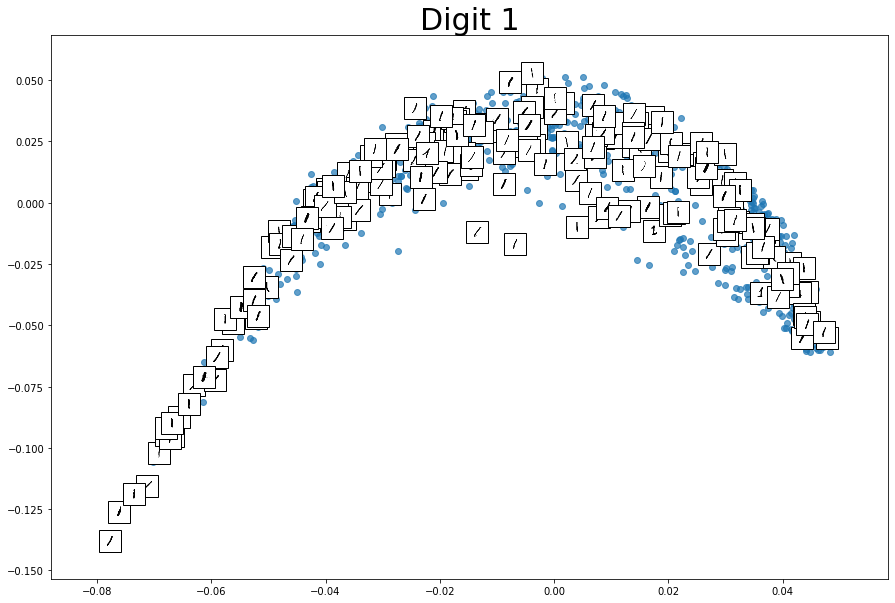

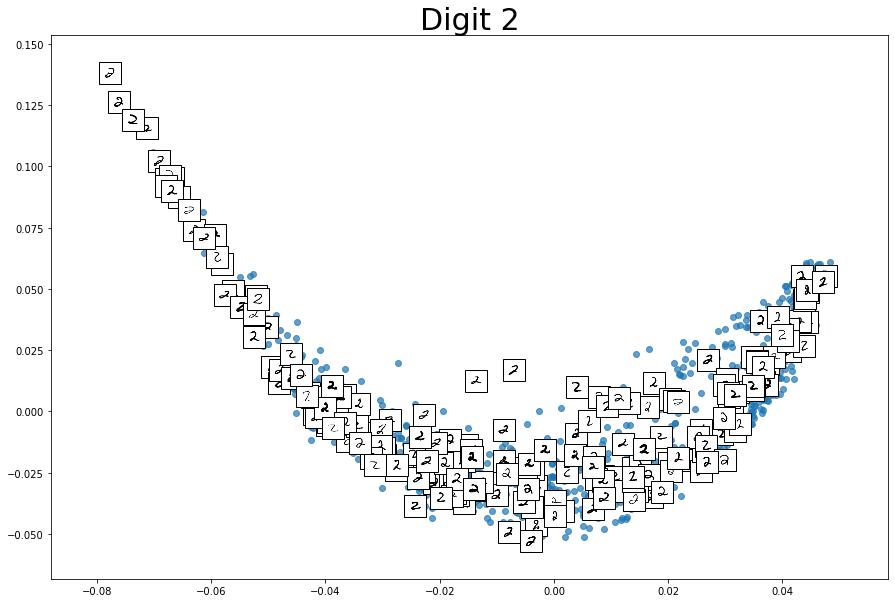

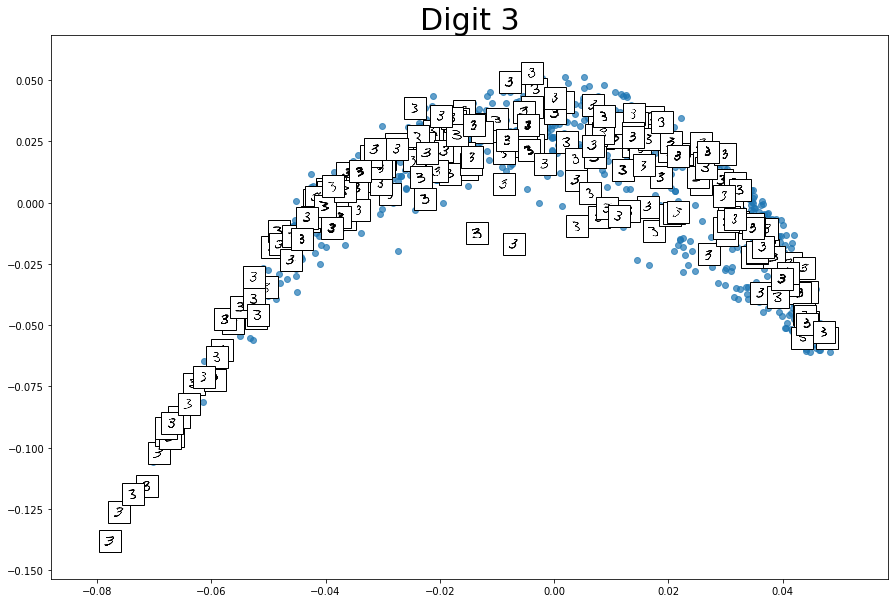

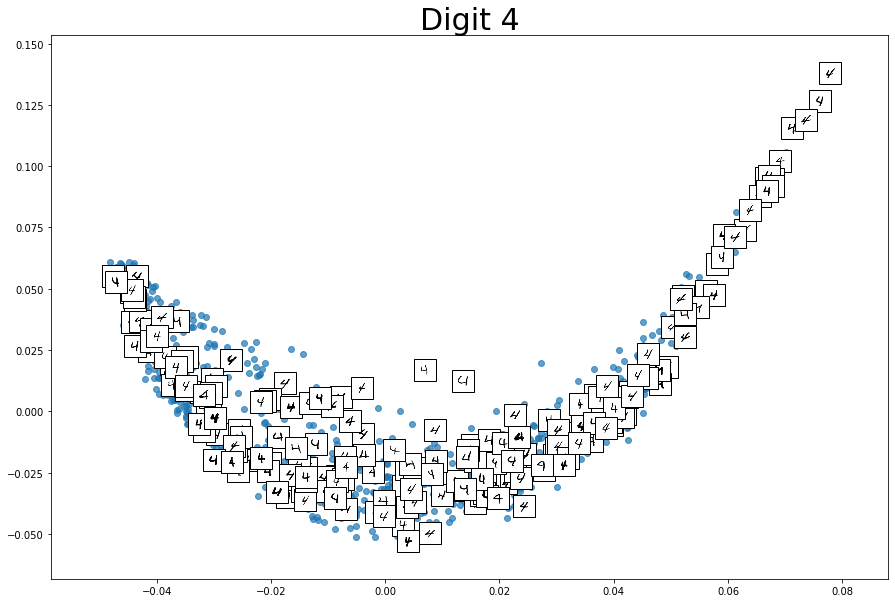

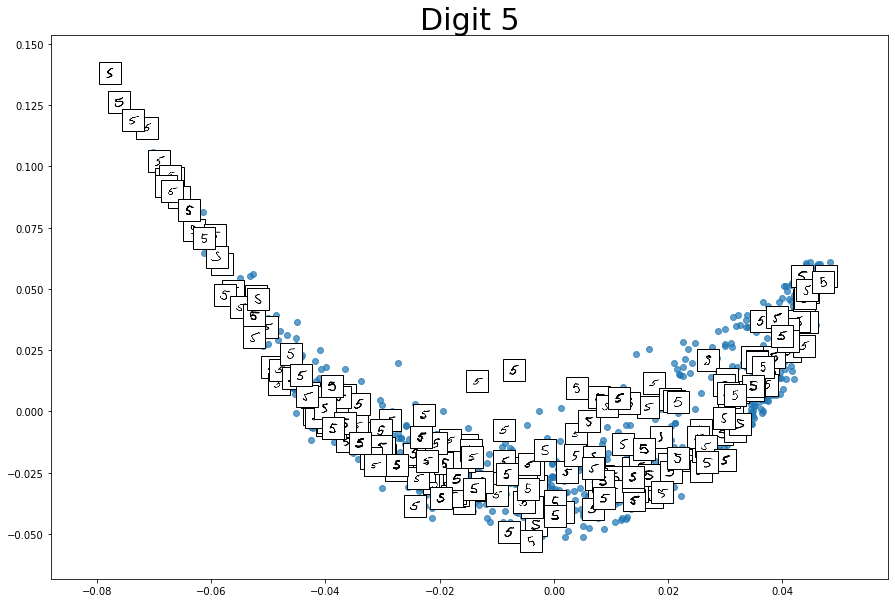

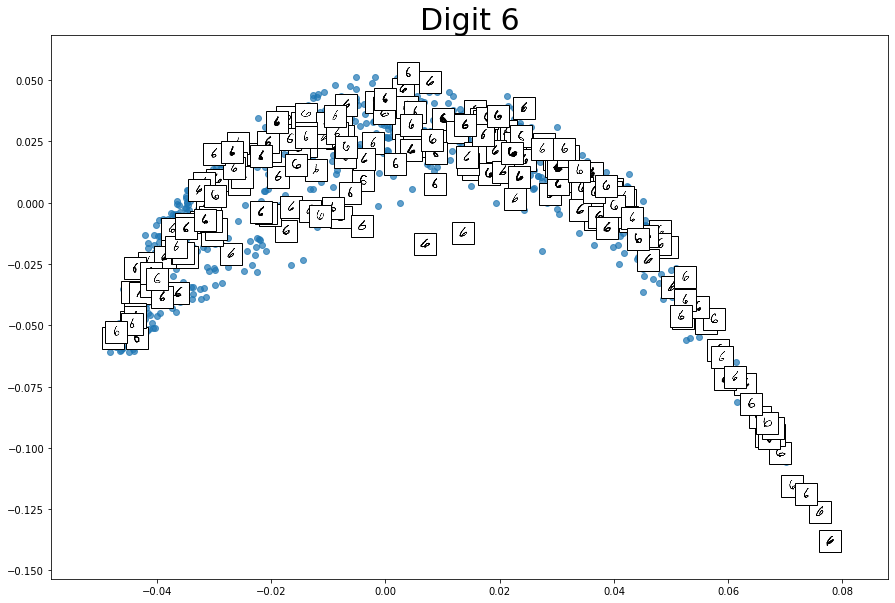

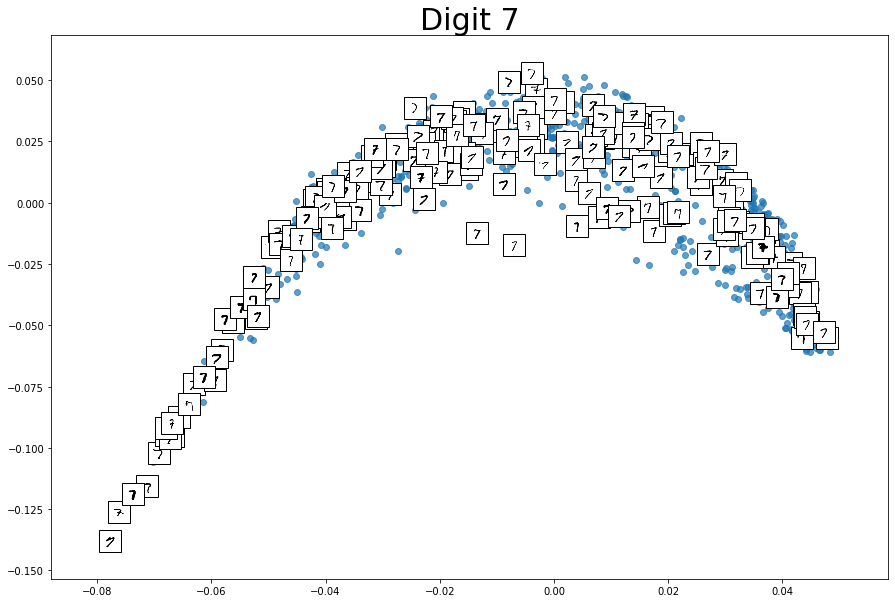

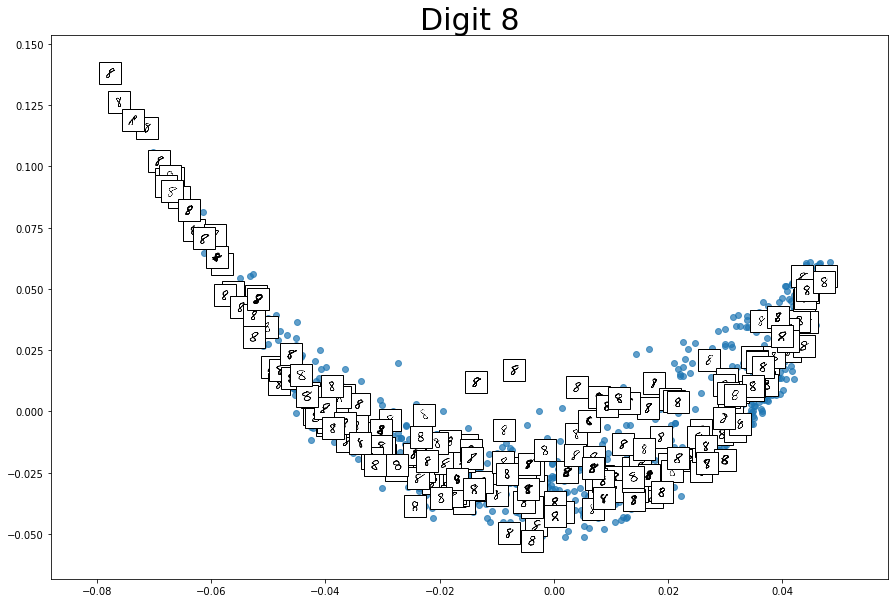

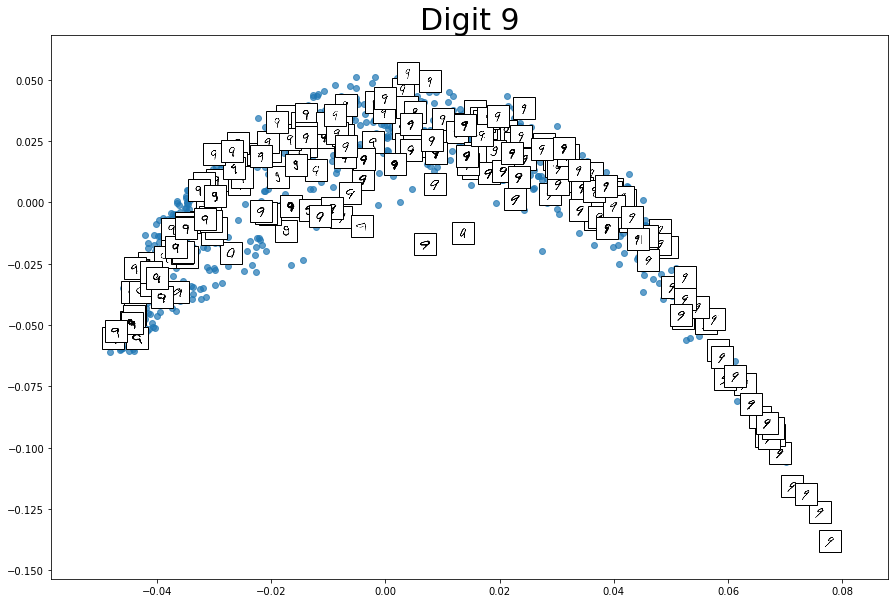

In [181]:
for i in range(10):
    Xi = X[y==i]
    reduced_X = lle(X2,
                d = 2,
                n_neighbors = 15)
    plt.figure(figsize=(15,10))
    plt.scatter(reduced_X[:,0],reduced_X[:,1], alpha = 0.7)
    plt.title('Digit '+str(i), fontsize=30)
    
    ax = plt.gcf().gca()  # get current axes in current figure    
    n_digits = 200    
    for i in range(n_digits):
        image = Xi[i].reshape(28, 28)
        image_coord = reduced_X[i]
        imagebox = AnnotationBbox(OffsetImage(image, zoom=.5, cmap="binary"), image_coord)
        ax.add_artist(imagebox)

## obj74 from coil-100

### 11.3.4 Problems

**Problem 1 (for M562 students and brave M462 students):** Let $A$ be an $m\times n$ matrix (with $m>n$), and let $b$ be an $m$ component vector.
Consider the following constrained optimization problem:

\begin{align}
&\min_x \| Ax - b \|_2^2 \\
&\mbox{subject to }\, \sum_{j=1}^n x_i = 1
\end{align}

**(a)** Suppose $\sum_{j=1}^n x_i = 1$ and define the $m\times n$ matrix $B = \begin{bmatrix} b & b & \cdots & b\end{bmatrix}$, show  $ \| Ax-b\|_2^2 = x^T(A-B)^T(A-B)x$.

**(b)** Using Lagrange multipliers, solve the constrained optimization problem.